### Data Modeling

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [2]:
# Load the data
df = pd.read_csv('PG_RESULTS_REDUCED4.csv')
df.head()

,index,Birth_Sex,Age,Race,State,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,5341,2,8,8.0,2,2,2,4.0,1.0,1,...,2.0,2,1.0,1,1,1.0,1.0,3,2,7
1,5342,2,11,3.0,2,1,1,3.0,3.0,1,...,2.0,2,1.0,2,2,1.0,1.0,5,1,8
2,5343,2,5,1.0,2,1,2,3.0,3.0,2,...,2.0,2,NaN,2,1,1.0,1.0,5,4,7
3,5344,1,8,1.0,2,1,1,2.0,3.0,1,...,2.0,2,1.0,2,1,1.0,1.0,5,4,8
4,5345,2,10,1.0,2,2,1,3.0,1.0,1,...,2.0,2,1.0,1,1,1.0,1.0,9,4,8


We will delete the following as those need not be used in Machine Learning and can be used in Visualizations
Metropolitan_y_n, 
Urban_Rural, 
Reported_Income, 
Education_Level

In [3]:
#Removing the columns State, index, Metropolitan_y_n, Urban_Rural, Reported_Income, Education_Level as its not needed for Machine Learning and can be utilized for visualizations
df = df.drop(["index","State","Metropolitan_y_n","Urban_Rural","Reported_Income","Education_Level"], axis=1)
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,2,8,8.0,2,2,4.0,1.0,1,1,1,1,2.0,2,1.0,1,1,7
1,2,11,3.0,1,1,3.0,3.0,1,1,2,1,2.0,2,1.0,2,2,8
2,2,5,1.0,1,2,3.0,3.0,2,1,1,1,2.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,1,2.0,2,1.0,2,1,8
4,2,10,1.0,2,1,3.0,1.0,1,1,1,1,2.0,2,1.0,1,1,8
5,2,12,1.0,1,1,3.0,1.0,1,1,1,1,2.0,2,NaN,2,2,6
6,2,1,1.0,1,2,2.0,3.0,2,1,1,1,2.0,2,NaN,2,2,7
7,2,8,1.0,1,1,2.0,3.0,1,1,1,1,2.0,2,2.0,2,1,8
8,1,10,1.0,2,2,NaN,3.0,2,9,9,1,2.0,2,NaN,2,1,8
9,1,9,1.0,1,1,2.0,3.0,1,1,1,1,2.0,2,2.0,2,1,7


From CDC website, we know for PHYSICAL_HEALTH we have 
when "Physical_Health"=1 then it means Zero days when physical health not good
when "Physical_Health"=2 then it means 1-13 days when physical health not good
when "Physical_Health"=3 then it means 14+ days when physical health not good
when "Physical_Health"=9 then it means Don’t know/ Refused/ Missing

In [4]:
df["Physical_Health"].value_counts()

1    263754
2     67458
3     39302
9      7415
Name: Physical_Health, dtype: int64

In [5]:
# Split Colonscopy NaNs into 3 bunches proportinately and update them with 1, 2, 3 to insert no bias to the model
idx = df['Physical_Health'].index[df['Physical_Health']==9]
df4 = df[df['Physical_Health'] != 9]
x = df4['Physical_Health'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[1]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[2]/100).round(1)) 
print(sample2_perct)
sample3_perct = int((total_len*x[3]/100).round(1))
print(sample3_perct)


second_update = sample1_perct + sample2_perct


df.loc[idx[0:sample1_perct], 'Physical_Health'] = 1
df.loc[idx[sample1_perct:second_update], 'Physical_Health'] = 2
df.loc[idx[second_update:total_len], 'Physical_Health'] = 3
# df.head(10)

7415
5278
1350
786


In [6]:
df["Physical_Health"].value_counts()

1    269032
2     68808
3     40089
Name: Physical_Health, dtype: int64

from the CDC website document about this dataset, we came to know from the SAS code that
Birth_Sex of 1 = Male and 2 = Female, we will change this to Male - 1 and Female - 0

In [7]:
#Unique values for Sex
df["Birth_Sex"].value_counts()

2    204766
1    173163
Name: Birth_Sex, dtype: int64

In [8]:
df.loc[df["Birth_Sex"] == 2, "Birth_Sex"] = 0
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,2,2,4.0,1.0,1,1,1,1,2.0,2,1.0,1,1,7
1,0,11,3.0,1,1,3.0,3.0,1,1,2,1,2.0,2,1.0,2,2,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,1,2.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,1,2.0,2,1.0,2,1,8
4,0,10,1.0,2,1,3.0,1.0,1,1,1,1,2.0,2,1.0,1,1,8


As per the CDC website, the Age for this column was categorized as below
when "Age"=1 then '18-24'
when "Age"=2 then '25-29'
when "Age"=3 then '30-34'
when "Age"=4 then '35-39'
when "Age"=5 then '40-44'
when "Age"=6 then '45-49'
when "Age"=7 then '50-54'
when "Age"=8 then '55-59'
when "Age"=9 then '60-64'
when "Age"=10 then '65-69'
when "Age"=11 then '70-74'
when "Age"=12 then '75-79'
when "Age"=13 then '80-84'
when "Age"=14 then 'NaN' -- missing

In [9]:
#Unique values for Age - delete 
df["Age"].value_counts()

10    39309
9     38972
11    35889
8     34259
7     29290
13    28842
6     24912
12    24832
5     24252
1     24235
4     24005
3     22002
2     19676
14     7454
Name: Age, dtype: int64

Looks like we have Age value 14 which were rows with missing values. Instead of dropping those rows, we will try to create 13 bunches of each value and add to the respective bins.

In [10]:
# Split Age column with value 14 into 13 bunches and update them with 1, to 13 to insert no bias to the model
idx = df['Age'].index[df['Age']==14]
df4 = df[df['Age'] != 14]
x = df4['Age'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[1]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[2]/100).round(1)) 
print(sample2_perct)
sample3_perct = int((total_len*x[3]/100).round(1))
print(sample3_perct)
sample4_perct = int((total_len*x[4]/100).round(1))
print(sample4_perct)
sample5_perct = int((total_len*x[5]/100).round(1))
print(sample5_perct)
sample6_perct = int((total_len*x[6]/100).round(1))
print(sample6_perct)
sample7_perct = int((total_len*x[7]/100).round(1))
print(sample7_perct)
sample8_perct = int((total_len*x[8]/100).round(1))
print(sample8_perct)
sample9_perct = int((total_len*x[9]/100).round(1))
print(sample9_perct)
sample10_perct = int((total_len*x[10]/100).round(1))
print(sample10_perct)
sample11_perct = int((total_len*x[11]/100).round(1))
print(sample11_perct)
sample12_perct = int((total_len*x[12]/100).round(1))
print(sample12_perct)
sample13_perct = int((total_len*x[13]/100).round(1))
print(sample13_perct)


second_update = sample1_perct + sample2_perct
third_update = second_update + sample3_perct
fourth_update = third_update + sample4_perct
fifth_update = fourth_update + sample5_perct
sixth_update = fifth_update + sample6_perct
seventh_update = sixth_update + sample7_perct
eight_update = seventh_update + sample8_perct
ninth_update = eight_update + sample9_perct
tenth_update = ninth_update + sample10_perct
eleventh_update = tenth_update + sample11_perct
twelveth_update = eleventh_update + sample12_perct
thirteenth_update = twelveth_update + sample13_perct


df.loc[idx[0:sample1_perct], 'Age'] = 1
df.loc[idx[sample1_perct:second_update], 'Age'] = 2
df.loc[idx[second_update:third_update], 'Age'] = 3
df.loc[idx[third_update:fourth_update], 'Age'] = 4
df.loc[idx[fourth_update:fifth_update], 'Age'] = 5
df.loc[idx[fifth_update:sixth_update], 'Age'] = 6
df.loc[idx[sixth_update:seventh_update], 'Age'] = 7
df.loc[idx[seventh_update:eight_update], 'Age'] = 8
df.loc[idx[eight_update:ninth_update], 'Age'] = 9
df.loc[idx[ninth_update:tenth_update], 'Age'] = 10
df.loc[idx[tenth_update:eleventh_update], 'Age'] = 11
df.loc[idx[eleventh_update:twelveth_update], 'Age'] = 12
df.loc[idx[twelveth_update:total_len], 'Age'] = 13


7454
487
395
442
483
488
501
589
689
784
790
722
499
580


In [11]:
df["Age"].value_counts()

10    40099
9     39756
11    36611
8     34948
7     29879
13    29427
6     25413
12    25331
5     24740
1     24722
4     24488
3     22444
2     20071
Name: Age, dtype: int64

--We know the following RACE from CDC website SAS code
when "Race"=1 then 'White'
when "Race"=2 then 'Black'
when "Race"=3 then 'American Indian/Alaskan Native'
when "Race"=4 then 'Asian'
when "Race"=5 then 'Native Hawaiian or other Pacific Islander only, Non-Hispanic'
when "Race"=6 then 'Other Race Only, Non-Hispanic'
when "Race" = 7 then 'Multiracial, Non-Hispanic'
when "Race"=8 then 'Hispanic'
when "Race"=9 then missing values , equivalent to NaN

In [12]:
# Unique values for Race delete
df["Race"].value_counts()

1.0    281929
8.0     31924
2.0     27054
4.0      9657
9.0      8056
7.0      7840
3.0      6433
6.0      3072
5.0      1963
Name: Race, dtype: int64

As we see the dataset contains the value 9 which is equivalent to NaN, we will try to modify these 8056 Races with derived values to each of the other valid Races

In [13]:
# Split Race column with value 9 into 8 bunches and update them with 1, to 8 to insert no bias to the model

idx = df['Race'].index[df['Race']==9]
df4 = df[df['Race'] != 9]
x = df4['Race'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[1]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[2]/100).round(1)) 
print(sample2_perct)
sample3_perct = int((total_len*x[3]/100).round(1))
print(sample3_perct)
sample4_perct = int((total_len*x[4]/100).round(1))
print(sample4_perct)
sample5_perct = int((total_len*x[5]/100).round(1))
print(sample5_perct)
sample6_perct = int((total_len*x[6]/100).round(1))
print(sample6_perct)
sample7_perct = int((total_len*x[7]/100).round(1))
print(sample7_perct)
sample8_perct = int((total_len*x[8]/100).round(1))
print(sample8_perct)



second_update = sample1_perct + sample2_perct
third_update = second_update + sample3_perct
fourth_update = third_update + sample4_perct
fifth_update = fourth_update + sample5_perct
sixth_update = fifth_update + sample6_perct
seventh_update = sixth_update + sample7_perct
eight_update = seventh_update + sample8_perct




df.loc[idx[0:sample1_perct], 'Race'] = 1
df.loc[idx[sample1_perct:second_update], 'Race'] = 2
df.loc[idx[second_update:third_update], 'Race'] = 3
df.loc[idx[third_update:fourth_update], 'Race'] = 4
df.loc[idx[fourth_update:fifth_update], 'Race'] = 5
df.loc[idx[fifth_update:sixth_update], 'Race'] = 6
df.loc[idx[sixth_update:seventh_update], 'Race'] = 7
df.loc[idx[seventh_update:total_len], 'Race'] = 8


8056
6140
589
140
210
42
66
170
695


In [14]:
# Unique values for Race
df["Race"].value_counts()

1.0    288069
8.0     32623
2.0     27643
4.0      9867
7.0      8010
3.0      6573
6.0      3138
5.0      2005
Name: Race, dtype: int64

From the CDC website the SAS code for OVERALL_HEALTH says 
when "Overall_Health" = 1 then 'BETTER/GOOD'
when "Overall_Health" = 2 then 'FAIR/POOR'
when "Overall_Health"= 9 then Missing values
So basically we can change 1 and 2 to 1 and 0 and instead of dropping the 9 rows, we can divide them equally into 1 and 0


In [15]:
# Unique values for Overall Health - 
df["Overall_Health"].value_counts()

1    321531
2     55656
9       742
Name: Overall_Health, dtype: int64

In [16]:
df.loc[df["Overall_Health"] == 2, "Overall_Health"] = 0
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.0,1.0,1,1,1,1,2.0,2,1.0,1,1,7
1,0,11,3.0,1,1,3.0,3.0,1,1,2,1,2.0,2,1.0,2,2,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,1,2.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,1,2.0,2,1.0,2,1,8
4,0,10,1.0,0,1,3.0,1.0,1,1,1,1,2.0,2,1.0,1,1,8


In [17]:
# Unique values for Overall Health
df["Overall_Health"].value_counts()

1    321531
0     55656
9       742
Name: Overall_Health, dtype: int64

In [18]:
#deleting rows with 9 

df = df[df.Overall_Health != 9]

In [19]:
# Unique values for Overall Health
df["Overall_Health"].value_counts()

1    321531
0     55656
Name: Overall_Health, dtype: int64

BMI values can be in various number as each person's BMI will be different. 
Lets check if there are any missing ones. And if there are , let's have them filled in with the mean value of that column

In [20]:
df["BMI_CDC_Categories"].isnull().sum() 

37871

In [21]:
# get mean of values in column S2 - fine
mean_bmi = df['BMI_CDC_Categories'].mean()
print('Mean of values in column BMI_CDC_Categories:')
print(mean_bmi)

Mean of values in column BMI_CDC_Categories:
2.9776462058965683


In [22]:
# Replace NaNs in column BMI_CDC_Categories with the
# mean of values in the same column
df['BMI_CDC_Categories'].fillna(value=df['BMI_CDC_Categories'].mean(), inplace=True)
print('Updated Dataframe:')
df.head()

Updated Dataframe:


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.0,1.0,1,1,1,1,2.0,2,1.0,1,1,7
1,0,11,3.0,1,1,3.0,3.0,1,1,2,1,2.0,2,1.0,2,2,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,1,2.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,1,2.0,2,1.0,2,1,8
4,0,10,1.0,0,1,3.0,1.0,1,1,1,1,2.0,2,1.0,1,1,8


From the CDC website we know that for Diabetes
when "Diabetes"=1 then 'Yes'
when "Diabetes"=2 then 'Yes, but only Gestational Diabetes'
when "Diabetes" =3 then 'No'
when "Diabetes"=4 then 'Borderline Diabetes'
when "Diabetes"=7 then 'NaN'
when "Diabetes"=9 then 'refused to answer

In [23]:
# Unique values for Diabetes - delete
df["Diabetes"].value_counts()

3.0    317861
1.0     47721
4.0      8006
2.0      3153
7.0       371
9.0        74
Name: Diabetes, dtype: int64

So we see that there are 7 and 9 values which is equivalent to null/NaNs which we can spread them accross other values instead of deleting those rows

In [24]:
# Split Diabetes column with value 7/9 into 4 bunches and update them with 1 to 4 to insert no bias to the model

idx = df['Diabetes'].index[(df['Diabetes']==7) | (df['Diabetes']==9)]

df4 = df[(df['Diabetes'] != 9) & (df['Diabetes'] != 7)]

x = df4['Diabetes'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[1]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[2]/100).round(1)) 
print(sample2_perct)
sample3_perct = int((total_len*x[3]/100).round(1))
print(sample3_perct)
sample4_perct = int((total_len*x[4]/100).round(1))
print(sample4_perct)

second_update = sample1_perct + sample2_perct
third_update = second_update + sample3_perct
fourth_update = third_update + sample4_perct

df.loc[idx[0:sample1_perct], 'Diabetes'] = 1
df.loc[idx[sample1_perct:second_update], 'Diabetes'] = 2
df.loc[idx[second_update:third_update], 'Diabetes'] = 3
df.loc[idx[third_update:total_len], 'Diabetes'] = 4



445
56
3
375
9


In [25]:
# Unique values for Diabetes
df["Diabetes"].value_counts()

3.0    318236
1.0     47777
4.0      8017
2.0      3156
Name: Diabetes, dtype: int64

From CDC website, we know for Mental_Health we have 
when "Mental_Health"=1 then it means Zero days when physical health not good
when "Mental_Health"=2 then it means 1-13 days when physical health not good
when "Mental_Health"=3 then it means 14+ days when physical health not good
when "Mental_Health"=9 then it means Don’t know/ Refused/ Missing

In [26]:
# Unique values for Mental_Health -- delete
df["Mental_Health"].value_counts()

1    240495
2     85348
3     44741
9      6603
Name: Mental_Health, dtype: int64

In [27]:
# Split Mental_Health 9 into 3 bunches proportinately and update them with 1, 2, 3 to insert no bias to the model

idx = df['Mental_Health'].index[df['Mental_Health']==9]
df4 = df[df['Mental_Health'] != 9]
x = df4['Mental_Health'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[1]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[2]/100).round(1)) 
print(sample2_perct)
sample3_perct = int((total_len*x[3]/100).round(1))
print(sample3_perct)


second_update = sample1_perct + sample2_perct


df.loc[idx[0:sample1_perct], 'Mental_Health'] = 1
df.loc[idx[sample1_perct:second_update], 'Mental_Health'] = 2
df.loc[idx[second_update:total_len], 'Mental_Health'] = 3


6603
4285
1520
797


In [28]:
# Unique values for Mental_Health
df["Mental_Health"].value_counts()

1    244780
2     86868
3     45539
Name: Mental_Health, dtype: int64

From the CDC website we know for Alcohol Usage
when "Alcohol_Usage" = 1 then 'NO'
when "Alcohol_Usage" = 2 then 'YES'
when "Alcohol_Usage" = 9 then 'NaN'
Lets get these values changed from 2 to 0

In [29]:
# Unique values for Alcohol_Usage TBD 1480-NO, 26562 - YES  DO IT AT THE BEGINNING
df["Alcohol_Usage"].value_counts()

1    326502
9     27926
2     22759
Name: Alcohol_Usage, dtype: int64

In [30]:
df.loc[df["Alcohol_Usage"] == 2, "Alcohol_Usage"] = 0
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,2.0,2,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,2,1,2.0,2,1.0,2,2,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,2.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,1.0,2,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,2.0,2,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,2.0,2,NaN,2,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,2.0,2,NaN,2,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,2.0,2,1,8
8,1,10,1.0,0,2,2.977646,3.0,2,9,9,1,2.0,2,NaN,2,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2,2.0,2,1,7


In [31]:
# Split Alcohol_Usage 9 into 2 bunches and update them with 1 or 0 to insert no bias to the model

idx = df['Alcohol_Usage'].index[df['Alcohol_Usage']==9]
df4 = df[df['Alcohol_Usage'] != 9]
x = df4['Alcohol_Usage'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[0]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[1]/100).round(1)) 
print(sample2_perct)


df.loc[idx[0:sample1_perct], 'Alcohol_Usage'] = 0
df.loc[idx[sample1_perct:total_len], 'Alcohol_Usage'] = 1


27926
1819
26106


In [32]:
# Unique values for Alcohol_Usage
df["Alcohol_Usage"].value_counts()

1    352609
0     24578
Name: Alcohol_Usage, dtype: int64

From the CDC website we know for Tobacco Usage
when "Tobacco_Usage" = 1 then 'NO'
when "Tobacco_Usage" = 2 then 'YES'
when "Tobacco_Usage" = 9 then 'NaN'
Lets get these values changed from 2 to 0

In [33]:
# Unique values for Tobacco_Usage, PROPORTINATE , MOVE IT TO THE TOP BEFORE DROPPING ROWS
df["Tobacco_Usage"].value_counts()

1    309117
2     48781
9     19289
Name: Tobacco_Usage, dtype: int64

In [34]:
df.loc[df["Tobacco_Usage"] == 2, "Tobacco_Usage"] = 0
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.0,1.0,1,1,1,1,2.0,2,1.0,1,1,7
1,0,11,3.0,1,1,3.0,3.0,1,1,0,1,2.0,2,1.0,2,2,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,1,2.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,1,2.0,2,1.0,2,1,8
4,0,10,1.0,0,1,3.0,1.0,1,1,1,1,2.0,2,1.0,1,1,8


In [35]:
# Split Tobacco_Usage 9 into 2 bunches and update them with 1 or 0 to insert no bias to the model
idx = df['Tobacco_Usage'].index[df['Tobacco_Usage']==9]
df4 = df[df['Tobacco_Usage'] != 9]
x = df4['Tobacco_Usage'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[0]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[1]/100).round(1)) 
print(sample2_perct)


df.loc[idx[0:sample1_perct], 'Tobacco_Usage'] = 0
df.loc[idx[sample1_perct:total_len], 'Tobacco_Usage'] = 1


19289
2629
16659


From the CDC website we know for Asthma_History
case when "Asthma_History"=1 then 'NO'
when "Asthma_History"=2 then 'YES'
when "Asthma_History"=9 then 'NaN'

In [36]:
# Unique values for Asthma_History - DELETE
df["Asthma_History"].value_counts()

1    325725
2     50529
9       933
Name: Asthma_History, dtype: int64

In [37]:
# Deleting Asthma_History 9  
df = df[df.Asthma_History != 9]

In [38]:
# Unique values for Asthma_History
df["Asthma_History"].value_counts()

1    325725
2     50529
Name: Asthma_History, dtype: int64

We know that for Kidney_Disease
when "Kidney_Disease"=1 then 'YES'
when "Kidney_Disease"=2 then 'NO'
when "Kidney_Disease"=7 then 'NaN'
when "Kidney_Disease"=9 then Refused to answer

In [39]:
# Unique values for Kidney_Disease - 81 -SPREAD IT 
df["Kidney_Disease"].value_counts()

2.0    361526
1.0     13702
7.0       953
9.0        72
Name: Kidney_Disease, dtype: int64

In [40]:
df.loc[df["Kidney_Disease"] == 2, "Kidney_Disease"] = 0
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.0,1.0,1,1,1,1,0.0,2,1.0,1,1,7
1,0,11,3.0,1,1,3.0,3.0,1,1,0,1,0.0,2,1.0,2,2,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,1,0.0,2,NaN,2,1,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,1,0.0,2,1.0,2,1,8
4,0,10,1.0,0,1,3.0,1.0,1,1,1,1,0.0,2,1.0,1,1,8


In [41]:
# Split Kidney_Disease column with value 7/9 into 2 bunches and update them with 1 or 0 to insert no bias to the model
idx = df['Kidney_Disease'].index[(df['Kidney_Disease']==9) | (df['Kidney_Disease']==7)]
df4 = df[(df['Kidney_Disease'] != 7) & (df['Kidney_Disease'] != 9)]
x = df4['Kidney_Disease'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[0]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[1]/100).round(1)) 
print(sample2_perct)


df.loc[idx[0:sample1_perct], 'Kidney_Disease'] = 0
df.loc[idx[sample1_perct:total_len], 'Kidney_Disease'] = 1


1025
987
37


In [42]:
# Unique values for Kidney_Disease
df["Kidney_Disease"].value_counts()

0.0    362513
1.0     13740
Name: Kidney_Disease, dtype: int64

We know that for Stroke
when "Stroke" = 1 then 'YES'
when "Stroke" = 2 then 'NO'
when "Stroke" = 7 then 'NaN'
when "Stroke" = 9 then refused to answer
end "Stroke",

In [43]:
# Unique values for Stroke -
df["Stroke"].value_counts()

2    361498
1     14101
7       636
9        19
Name: Stroke, dtype: int64

In [44]:
df.loc[df["Stroke"] == 2, "Stroke"] = 0
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,7
1,0,11,3.0,1,1,3.000000,3.0,1,1,0,1,0.0,0,1.0,2,2,8
2,0,5,1.0,1,2,3.000000,3.0,2,1,1,1,0.0,0,NaN,2,1,7
3,1,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,1.0,2,1,8
4,0,10,1.0,0,1,3.000000,1.0,1,1,1,1,0.0,0,1.0,1,1,8
5,0,12,1.0,1,1,3.000000,1.0,1,1,1,1,0.0,0,NaN,2,2,6
6,0,1,1.0,1,2,2.000000,3.0,2,1,1,1,0.0,0,NaN,2,2,7
7,0,8,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,2,1,8
8,1,10,1.0,0,2,2.977646,3.0,2,0,0,1,0.0,0,NaN,2,1,8
9,1,9,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0,2.0,2,1,7


In [45]:
# Split Stroke column with value 7/9 into 2 bunches and update them with 1 or 0 to insert no bias to the model
idx = df['Stroke'].index[(df['Stroke']==9) | (df['Stroke']==7)]
df4 = df[(df['Stroke'] != 7) & (df['Stroke'] != 9)]
x = df4['Stroke'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[0]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[1]/100).round(1)) 
print(sample2_perct)


df.loc[idx[0:sample1_perct], 'Stroke'] = 0
df.loc[idx[sample1_perct:total_len], 'Stroke'] = 1


655
630
24


In [46]:
# Unique values for Stroke
df["Stroke"].value_counts()

0    362128
1     14126
Name: Stroke, dtype: int64

In [47]:
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.0,1.0,1,1,1,1,0.0,0,1.0,1,1,7
1,0,11,3.0,1,1,3.0,3.0,1,1,0,1,0.0,0,1.0,2,2,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,1,0.0,0,NaN,2,1,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,1,0.0,0,1.0,2,1,8
4,0,10,1.0,0,1,3.0,1.0,1,1,1,1,0.0,0,1.0,1,1,8


We can see from above that Colonscopy column has some NaN values which we will modify to 1, 2, 3 in equal weights

In [48]:
df["Colonoscopy"].value_counts() 

1.0    114488
3.0     42808
2.0     10436
Name: Colonoscopy, dtype: int64

In [49]:
# Split Colonscopy NaNs into 3 bunches and update them with 1, 2, 3 to insert no bias to the model

# idx = df['Colonoscopy'].index[df['Colonoscopy']==9]
idx=df['Colonoscopy'].index[df['Colonoscopy'].isna()]
# df4 = df[df['Colonoscopy'] != 9]
df4 = df[~df['Colonoscopy'].isna()]
x = df4['Colonoscopy'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[1]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[2]/100).round(1)) 
print(sample2_perct)
sample3_perct = int((total_len*x[3]/100).round(1))
print(sample3_perct)


second_update = sample1_perct + sample2_perct


df.loc[idx[0:sample1_perct], 'Colonoscopy'] = 1
df.loc[idx[sample1_perct:second_update], 'Colonoscopy'] = 2
df.loc[idx[second_update:total_len], 'Colonoscopy'] = 3


208522
142329
12973
53218


In [50]:
df["Colonoscopy"].value_counts()

1.0    256817
3.0     96028
2.0     23409
Name: Colonoscopy, dtype: int64

CDC website says that for Prior Heart Disease
when "Prior_Heart_Disease" = 1 then 'Yes, Reported Heart Disease'
when "Prior_Heart_Disease" = 2 then 'No, Did Not Report Heart Disease'
So we will change 2 to 0 for no heart disease

In [51]:
df["Prior_Heart_Disease"].value_counts()

2    344459
1     31795
Name: Prior_Heart_Disease, dtype: int64

In [52]:
df.loc[df["Prior_Heart_Disease"] == 2, "Prior_Heart_Disease"] = 0
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.0,1.0,1,1,1,1,0.0,0,1.0,1,1,7
1,0,11,3.0,1,1,3.0,3.0,1,1,0,1,0.0,0,1.0,0,2,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,1,0.0,0,1.0,0,1,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,1,0.0,0,1.0,0,1,8
4,0,10,1.0,0,1,3.0,1.0,1,1,1,1,0.0,0,1.0,1,1,8


In [53]:
df["Prior_Heart_Disease"].value_counts()

0    344459
1     31795
Name: Prior_Heart_Disease, dtype: int64

In [54]:
df = df.rename(columns={"Prior_Heart_Disease": "Heart_Disease"}, errors="raise")

We know from CDC website that for Physical Activity
when "Physical_Activity" = 1 then 'Yes, Physical Activities'
when "Physical_Activity" = 2 then 'No Physical Activities'
else 'NaN'

In [55]:
df["Physical_Activity"].value_counts()

1    288568
2     87193
9       493
Name: Physical_Activity, dtype: int64

In [56]:
df.loc[df["Physical_Activity"] == 2, "Physical_Activity"] = 0
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,8.0,0,2,4.0,1.0,1,1,1,1,0.0,0,1.0,1,1,7
1,0,11,3.0,1,1,3.0,3.0,1,1,0,1,0.0,0,1.0,0,0,8
2,0,5,1.0,1,2,3.0,3.0,2,1,1,1,0.0,0,1.0,0,1,7
3,1,8,1.0,1,1,2.0,3.0,1,1,1,1,0.0,0,1.0,0,1,8
4,0,10,1.0,0,1,3.0,1.0,1,1,1,1,0.0,0,1.0,1,1,8


In [57]:
# Split Physical_Activity column with value 9 into 2 bunches and update them with 1 or 0 to insert no bias to the model

idx = df['Physical_Activity'].index[df['Physical_Activity']==9]
df4 = df[df['Physical_Activity'] != 9]
x = df4['Physical_Activity'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[0]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[1]/100).round(1)) 
print(sample2_perct)


df.loc[idx[0:sample1_perct], 'Physical_Activity'] = 0
df.loc[idx[sample1_perct:total_len], 'Physical_Activity'] = 1


493
114
378


In [58]:
df["Physical_Activity"].value_counts()

1    288947
0     87307
Name: Physical_Activity, dtype: int64

In [59]:
df["Avg_Hours_of_Sleep"].value_counts()

8     115922
7     113313
6      78125
5      22928
9      18800
10      9345
4       9233
12      2638
3       2473
2       1005
1        688
11       551
14       284
16       278
15       236
13       127
18       124
20        82
24        51
17        25
22        11
23         7
19         6
21         2
Name: Avg_Hours_of_Sleep, dtype: int64

Lets check if all data are clean

In [60]:
df.isnull().sum()

Birth_Sex             0
Age                   0
Race                  1
Overall_Health        0
Physical_Health       0
BMI_CDC_Categories    0
Diabetes              1
Mental_Health         0
Alcohol_Usage         0
Tobacco_Usage         0
Asthma_History        0
Kidney_Disease        1
Stroke                0
Colonoscopy           0
Heart_Disease         0
Physical_Activity     0
Avg_Hours_of_Sleep    0
dtype: int64

From the above we see that there are only 3 NaN rows, we can delete them.

In [61]:
df.dropna(inplace=True)
df.isnull().sum()

Birth_Sex             0
Age                   0
Race                  0
Overall_Health        0
Physical_Health       0
BMI_CDC_Categories    0
Diabetes              0
Mental_Health         0
Alcohol_Usage         0
Tobacco_Usage         0
Asthma_History        0
Kidney_Disease        0
Stroke                0
Colonoscopy           0
Heart_Disease         0
Physical_Activity     0
Avg_Hours_of_Sleep    0
dtype: int64

Now the dataset looks clean and is ready for modelling

In [62]:
df.nunique()

Birth_Sex              2
Age                   13
Race                   8
Overall_Health         2
Physical_Health        3
BMI_CDC_Categories     5
Diabetes               4
Mental_Health          3
Alcohol_Usage          2
Tobacco_Usage          2
Asthma_History         2
Kidney_Disease         2
Stroke                 2
Colonoscopy            3
Heart_Disease          2
Physical_Activity      2
Avg_Hours_of_Sleep    24
dtype: int64

In [63]:
# categorical columns with 2 categories which already has 0 and 1 values. so no neeed to do Label encoding
cat_col = ['Birth_Sex', 'Overall_Health', 'Alcohol_Usage', 'Tobacco_Usage', 'Asthma_History', 'Kidney_Disease', 'Stroke', 'Physical_Activity']
# categoricall columns with more than 2 unqiue values
encode_col = ['Age', 'Race', 'Physical_Health', 'BMI_CDC_Categories', 'Diabetes', 'Mental_Health', 'Colonoscopy']

df[encode_col].nunique()

Age                   13
Race                   8
Physical_Health        3
BMI_CDC_Categories     5
Diabetes               4
Mental_Health          3
Colonoscopy            3
dtype: int64

In [64]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[encode_col]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(encode_col)
encode_df.head()


C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,...,Diabetes_1.0,Diabetes_2.0,Diabetes_3.0,Diabetes_4.0,Mental_Health_1,Mental_Health_2,Mental_Health_3,Colonoscopy_1.0,Colonoscopy_2.0,Colonoscopy_3.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [65]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(encode_col,1)
df.head()

C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Birth_Sex,Overall_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep,...,Diabetes_1.0,Diabetes_2.0,Diabetes_3.0,Diabetes_4.0,Mental_Health_1,Mental_Health_2,Mental_Health_3,Colonoscopy_1.0,Colonoscopy_2.0,Colonoscopy_3.0
0,0,0,1,1,1,0.0,0,1,1,7,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,1,1,0,1,0.0,0,0,0,8,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,1,1,1,1,0.0,0,0,1,7,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,1,1,1,1,0.0,0,0,1,8,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,0,1,1,1,0.0,0,1,1,8,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [66]:
df2 = df.copy()
df2.head(10)

,Birth_Sex,Overall_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep,...,Diabetes_1.0,Diabetes_2.0,Diabetes_3.0,Diabetes_4.0,Mental_Health_1,Mental_Health_2,Mental_Health_3,Colonoscopy_1.0,Colonoscopy_2.0,Colonoscopy_3.0
0,0,0,1,1,1,0.0,0,1,1,7,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,1,1,0,1,0.0,0,0,0,8,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,1,1,1,1,0.0,0,0,1,7,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,1,1,1,1,0.0,0,0,1,8,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,0,1,1,1,0.0,0,1,1,8,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,0,1,1,1,1,0.0,0,0,0,6,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,0,1,1,1,1,0.0,0,0,0,7,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7,0,1,1,1,1,0.0,0,0,1,8,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,1,0,0,0,1,0.0,0,0,1,8,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9,1,1,1,1,1,0.0,0,0,1,7,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [67]:
y = df2["Heart_Disease"]
X = df2.drop(columns="Heart_Disease")

In [68]:
from sklearn.model_selection import train_test_split
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
Counter(y_train)

Counter({0: 257186, 1: 23749})

In [69]:
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({0: 257186, 1: 257186})

In [70]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
# X_scaler = scaler.fit(X_train)
X_scaler = scaler.fit(X_resampled)

# Scaling the data.
# X_train_scaled = X_scaler.transform(X_train)
X_train_scaled = X_scaler.transform(X_resampled)
X_test_scaled = X_scaler.transform(X_test)

In [71]:
X_test.head()

,Birth_Sex,Overall_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Physical_Activity,Avg_Hours_of_Sleep,Age_1,...,Diabetes_1.0,Diabetes_2.0,Diabetes_3.0,Diabetes_4.0,Mental_Health_1,Mental_Health_2,Mental_Health_3,Colonoscopy_1.0,Colonoscopy_2.0,Colonoscopy_3.0
292463,1,1,1,1,1,0.0,0,1,7,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
48092,1,0,1,1,2,1.0,1,1,12,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
228512,0,1,1,1,1,0.0,0,1,7,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
40634,1,1,1,1,1,0.0,0,1,7,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
217202,0,1,0,1,1,0.0,0,1,8,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [73]:
# Creating various classifier instances as a list.

models = [LogisticRegression(solver='liblinear', random_state=1), 
          tree.DecisionTreeClassifier(), 
          RandomForestClassifier(n_estimators=100, random_state=1),
          ExtraTreesClassifier(random_state=1, n_estimators=100), 
          ]

compare = pd.DataFrame(columns=["Model", "F1", "Recall", "Accuracy", "Probability", "Prediction"])
acc_list = []

for m in models:
#     m.fit(X_train_scaled, y_train)
    m.fit(X_resampled, y_resampled)
    y_pred = m.predict(X_test_scaled)
    y_prob = m.predict_proba(X_test_scaled)
    f1 = f1_score(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    
    compare = compare.append({'Model': m, 'F1': f1, 'Recall': recall, 'Accuracy': acc, 'Probability': y_prob, 'Prediction': y_pred}, ignore_index=True)
    acc_list.append(acc)
    print(f'Model used: {str(m)}')
    print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
    print(f'Precision Score: {precision_score(y_test,y_pred)}')
    print(f'Recall Score: {recall_score(y_test,y_pred)}')
    print(f'F1 Score: {f1_score(y_test,y_pred)}')
    print(f'Probability: {y_prob}')
    print(f'Prediction: {y_pred}')
    compare
    print('-------------------------------------', '\n')


C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


Model used: LogisticRegression(random_state=1, solver='liblinear')
Accuracy Score: 0.8140744300282984
Precision Score: 0.23136988626718724
Recall Score: 0.5165487620010106
F1 Score: 0.31959044902106376
Probability: [[7.96912240e-01 2.03087760e-01]
 [5.78622886e-06 9.99994214e-01]
 [9.27147271e-01 7.28527289e-02]
 ...
 [9.23450007e-01 7.65499928e-02]
 [3.87568774e-01 6.12431226e-01]
 [7.77019075e-01 2.22980925e-01]]
Prediction: [0 1 0 ... 0 1 0]
------------------------------------- 



C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


Model used: DecisionTreeClassifier()
Accuracy Score: 0.8548133909979176
Precision Score: 0.0983026874115983
Recall Score: 0.08779686710459828
F1 Score: 0.09275323635393033
Probability: [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
Prediction: [0 0 0 ... 1 0 0]
------------------------------------- 



C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Model used: RandomForestClassifier(random_state=1)
Accuracy Score: 0.9136526242725186
Precision Score: 0.3990498812351544
Recall Score: 0.04244567963617989
F1 Score: 0.07672984699703128
Probability: [[0.96 0.04]
 [0.37 0.63]
 [0.94 0.06]
 ...
 [0.92 0.08]
 [0.87 0.13]
 [0.98 0.02]]
Prediction: [0 1 0 ... 0 0 0]
------------------------------------- 



C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  "X does not have valid feature names, but"


Model used: ExtraTreesClassifier(random_state=1)
Accuracy Score: 0.9157349564845961
Precision Score: 0.5401929260450161
Recall Score: 0.021222839818089943
F1 Score: 0.04084113285523277
Probability: [[0.88       0.12      ]
 [0.31       0.69      ]
 [0.95214286 0.04785714]
 ...
 [0.88       0.12      ]
 [0.81       0.19      ]
 [0.92       0.08      ]]
Prediction: [0 1 0 ... 0 0 0]
------------------------------------- 



In [74]:
compare

,Model,F1,Recall,Accuracy,Probability,Prediction
0,"LogisticRegression(random_state=1, solver='lib...",0.319590,0.516549,0.814074,"[[0.7969122401341844, 0.20308775986581565], [5...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,DecisionTreeClassifier(),0.092753,0.087797,0.854813,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"(DecisionTreeClassifier(max_features='auto', r...",0.076730,0.042446,0.913653,"[[0.96, 0.04], [0.37, 0.63], [0.94, 0.06], [0....","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"(ExtraTreeClassifier(random_state=1791095845),...",0.040841,0.021223,0.915735,"[[0.88, 0.12], [0.31, 0.69], [0.95214285714285...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Lets try Logistic regression with taking away different columns and see the impact in accuracy, recall etc.

In [75]:
def log_regress_iteration(df, drop_col, compare_log):
    df2 = df.copy()
    y = df2["Heart_Disease"]
    
#     X = df2.drop(columns=drop_col).drop(columns='Heart_Disease')
    X = df2.loc[:,~df2.columns.str.contains(drop_col)].drop(columns='Heart_Disease')
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    ros = RandomOverSampler(random_state=1)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    
    # Creating a StandardScaler instance.
    scaler = StandardScaler()
    # Fitting the Standard Scaler with the training data.
    X_scaler = scaler.fit(X_resampled)

    # Scaling the data.
    X_train_scaled = X_scaler.transform(X_resampled)
    X_test_scaled = X_scaler.transform(X_test)
    # Creating various classifier instances as a list.

    log_model = LogisticRegression(solver='liblinear', random_state=1)   


    log_model.fit(X_resampled, y_resampled)
    
    y_pred = log_model.predict(X_test_scaled)
    y_prob = log_model.predict_proba(X_test_scaled)
    f1 = f1_score(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred, pos_label='positive', average=None)

    compare_log = compare_log.append({'Model': log_model, 'drop column': drop_col, 'F1': f1, 'Recall': recall, 'Accuracy': acc, 'Probability': y_prob, 'Prediction': y_pred}, ignore_index=True)
    return compare_log
    print(f'Model used: {str(log_model)}')
    print(f'Drop Column: {drop_col}')
    print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
    print(f'Precision Score: {precision_score(y_test,y_pred)}')
    print(f'Recall Score: {recall_score(y_test,y_pred)}')
    print(f'F1 Score: {f1_score(y_test,y_pred)}')
    print(f'Probability: {y_prob}')
    print(f'Prediction: {y_pred}')
    compare_log
    print('-------------------------------------', '\n')

In [76]:
df.head()

,Birth_Sex,Overall_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep,...,Diabetes_1.0,Diabetes_2.0,Diabetes_3.0,Diabetes_4.0,Mental_Health_1,Mental_Health_2,Mental_Health_3,Colonoscopy_1.0,Colonoscopy_2.0,Colonoscopy_3.0
0,0,0,1,1,1,0.0,0,1,1,7,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,1,1,0,1,0.0,0,0,0,8,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,1,1,1,1,0.0,0,0,1,7,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,1,1,1,1,0.0,0,0,1,8,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,0,1,1,1,0.0,0,1,1,8,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [77]:

compare_log = pd.DataFrame(columns=["Model", "drop column", "F1", "Recall", "Accuracy", "Probability", "Prediction"])
birth_sex = log_regress_iteration(df, "Birth_Sex", compare_log)
age = log_regress_iteration(df, "Age", birth_sex)
race = log_regress_iteration(df, "Race", age)
overall_health = log_regress_iteration(df, "Overall_Health", race)
physical_health = log_regress_iteration(df, "Physical_Health", overall_health)
bmi = log_regress_iteration(df, "BMI_CDC_Categories", physical_health)
diabetes = log_regress_iteration(df, "Diabetes", bmi)
mental_Health = log_regress_iteration(df, "Mental_Health", diabetes)
alcohol_Usage = log_regress_iteration(df, "Alcohol_Usage", mental_Health)
tobacco_Usage = log_regress_iteration(df, "Tobacco_Usage", alcohol_Usage)
asthma_History = log_regress_iteration(df, "Asthma_History", tobacco_Usage)
kidney_Disease = log_regress_iteration(df, "Kidney_Disease", asthma_History)
stroke = log_regress_iteration(df, "Stroke", kidney_Disease)
colonoscopy = log_regress_iteration(df, "Colonoscopy", stroke)
physical_Activity = log_regress_iteration(df, "Physical_Activity", colonoscopy)
sleep_time = log_regress_iteration(df, "Avg_Hours_of_Sleep", physical_Activity)

final_df = sleep_time.copy()
final_df

C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.p

C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.p

,Model,drop column,F1,Recall,Accuracy,Probability,Prediction
0,"LogisticRegression(random_state=1, solver='lib...",Birth_Sex,0.318919,"[0.8431818446862354, 0.5127912867274569]",0.815324,"[[0.6409015978886354, 0.35909840211136457], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
1,"LogisticRegression(random_state=1, solver='lib...",Age,0.320139,"[0.8436366604858365, 0.5141843971631206]",0.815858,"[[0.8301157728817109, 0.1698842271182891], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
2,"LogisticRegression(random_state=1, solver='lib...",Race,0.322177,"[0.843624998542257, 0.5181104356636271]",0.816178,"[[0.8031070476870644, 0.1968929523129356], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
3,"LogisticRegression(random_state=1, solver='lib...",Overall_Health,0.274659,"[0.8723833514093459, 0.3798125633232016]",0.830851,"[[0.6905720752377446, 0.30942792476225545], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,"LogisticRegression(random_state=1, solver='lib...",Physical_Health,0.319212,"[0.8413042717699332, 0.5172239108409321]",0.813978,"[[0.8054218520630737, 0.1945781479369263], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
5,"LogisticRegression(random_state=1, solver='lib...",BMI_CDC_Categories,0.318969,"[0.8411993142777175, 0.5169706180344478]",0.813861,"[[0.8107934352425022, 0.18920656475749778], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
6,"LogisticRegression(random_state=1, solver='lib...",Diabetes,0.318534,"[0.8412226381648765, 0.5160840932117527]",0.813807,"[[0.8077058939693004, 0.1922941060306996], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
7,"LogisticRegression(random_state=1, solver='lib...",Mental_Health,0.319350,"[0.8411876523341381, 0.5177304964539007]",0.813914,"[[0.8081043949898353, 0.19189560501016464], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
8,"LogisticRegression(random_state=1, solver='lib...",Alcohol_Usage,0.315483,"[0.8325461521417159, 0.5278622087132725]",0.806856,"[[0.7900477823826787, 0.2099522176173213], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
9,"LogisticRegression(random_state=1, solver='lib...",Tobacco_Usage,0.318820,"[0.8408144701395934, 0.5174772036474165]",0.813551,"[[0.8044895391224127, 0.19551046087758728], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."


In [78]:
final_df.head()

,Model,drop column,F1,Recall,Accuracy,Probability,Prediction
0,"LogisticRegression(random_state=1, solver='lib...",Birth_Sex,0.318919,"[0.8431818446862354, 0.5127912867274569]",0.815324,"[[0.6409015978886354, 0.35909840211136457], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
1,"LogisticRegression(random_state=1, solver='lib...",Age,0.320139,"[0.8436366604858365, 0.5141843971631206]",0.815858,"[[0.8301157728817109, 0.1698842271182891], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
2,"LogisticRegression(random_state=1, solver='lib...",Race,0.322177,"[0.843624998542257, 0.5181104356636271]",0.816178,"[[0.8031070476870644, 0.1968929523129356], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
3,"LogisticRegression(random_state=1, solver='lib...",Overall_Health,0.274659,"[0.8723833514093459, 0.3798125633232016]",0.830851,"[[0.6905720752377446, 0.30942792476225545], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,"LogisticRegression(random_state=1, solver='lib...",Physical_Health,0.319212,"[0.8413042717699332, 0.5172239108409321]",0.813978,"[[0.8054218520630737, 0.1945781479369263], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."


here we try dropping the Kidney_disease and Age to see the impact

In [79]:
df2 = df.copy()
y = df2["Heart_Disease"]

# X = df2.drop(columns='Heart_Disease').drop(columns="Kidney_Disease").drop(columns="Age")
X = df2.loc[:,~df2.columns.str.contains("Age")].drop(columns='Heart_Disease').drop(columns='Kidney_Disease')
drop_col = "KidneyandAge"
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_resampled)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_resampled)
X_test_scaled = X_scaler.transform(X_test)
# Creating various classifier instances as a list.

log_model = LogisticRegression(solver='liblinear', random_state=1)



log_model.fit(X_resampled, y_resampled)
y_pred = log_model.predict(X_test_scaled)
y_prob = log_model.predict_proba(X_test_scaled)
f1 = f1_score(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)
recall = recall_score(y_test,y_pred, pos_label='positive', average=None)

compare_log = compare_log.append({'Model': log_model, 'drop column': drop_col, 'F1': f1, 'Recall': recall, 'Accuracy': acc, 'Probability': y_prob, 'Prediction': y_pred}, ignore_index=True)
# return compare_log
print(f'Model used: {str(log_model)}')
print(f'Drop Column: {drop_col}')
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Precission Score: {precision_score(y_test,y_pred)}')
print(f'Recall Score: {recall_score(y_test,y_pred)}')
print(f'F1 Score: {f1_score(y_test,y_pred)}')
print(f'Probability: {y_prob}')
print(f'Prediction: {y_pred}')
compare_log
print('-------------------------------------', '\n')

C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


Model used: LogisticRegression(random_state=1, solver='liblinear')
Drop Column: KidneyandAge
Accuracy Score: 0.810454375567302
Precission Score: 0.22279734443569257
Recall Score: 0.5015197568389058
F1 Score: 0.30853135956369304
Probability: [[0.76844617 0.23155383]
 [0.76106012 0.23893988]
 [0.70339348 0.29660652]
 ...
 [0.80972309 0.19027691]
 [0.92442619 0.07557381]
 [0.82124588 0.17875412]]
Prediction: [0 0 0 ... 0 0 0]
------------------------------------- 



In [80]:
compare_log

,Model,drop column,F1,Recall,Accuracy,Probability,Prediction
0,"LogisticRegression(random_state=1, solver='lib...",KidneyandAge,0.308531,"[0.8389019113925527, 0.5015197568389058]",0.810454,"[[0.7684461693966252, 0.23155383060337473], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."


In [81]:
import matplotlib.pyplot as plt

In [82]:
acc_lables = [ "Logistic Regression", "DecisionTree","ExtraTree", "RandomForest"]

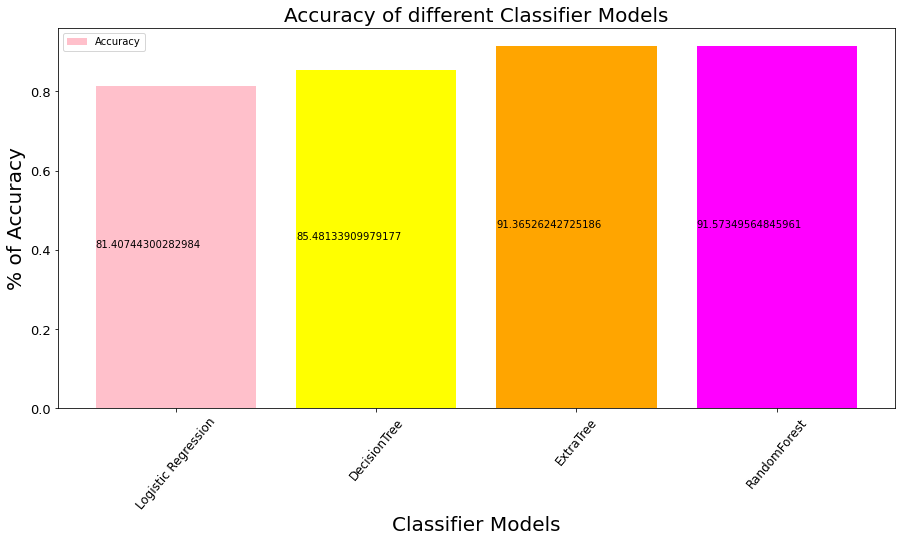

In [83]:
x_axis = acc_lables
y_axis = acc_list
colors = ['pink', 'yellow', 'orange', 'magenta']

# Create the plot
# setting figure size by using figure() function 
plt.figure(figsize = (15, 7))
      
bars = plt.bar(x_axis, y_axis, color=colors, label='Accuracy')
plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("% of Accuracy", fontsize = 20)
plt.title("Accuracy of different Classifier Models", fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 50)
plt.yticks(fontsize = 13)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval/2, yval*100)
    
# Add the legend.
plt.legend()
plt.show()